# Notebook 2: Similarity Search Index Performance Comparision
<img src="https://flickrcode.files.wordpress.com/2017/03/retrieval.png" alt="Coding">

## IVFFlat Index
**IVFFlat is a similarity search approximation method that uses cell partitioning to speed up nearest neighbor search. In this technique, the feature space is divided up into n-cells. The database vectors are assigned to one of these cells by some hashing function and then stored in an 'inverted file structure' formed of n inverted lists. When a query is made, some number (nprobe) will determine how many cells should be probed for k nearest neighbors. The search is then performed on only a narrowed down subset of the entire dataset, ignoring cells that are unlikely to have nearest neighbors.**

# LSH Index
**The LSH (Local Sensitive Hashing) index is another method provided by FAISS that speeds up search time by assigning each datapoint a new vector representation that requires less memory to store. The general idea behind LSH is to assign a hashcode to every datapoint in the the dataset. The idea being that datapoints that are closer together will have similar hashcodes.**
<img src="https://i.ytimg.com/vi/Arni-zkqMBA/hqdefault.jpg" alt="Coding">

## Import Libraries

In [200]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import statistics
import pandas
import faiss
import time
import sys

## Define Function for Reading fvec File Format

In [201]:
def fvecs_read(filename, c_contiguous=True):
    fv = np.fromfile(filename, dtype=np.float32)
    if fv.size == 0:
        return np.zeros((0, 0))
    dim = fv.view(np.int32)[0]
    assert dim > 0
    fv = fv.reshape(-1, 1 + dim)
    if not all(fv.view(np.int32)[:, 0] == dim):
        raise IOError("Non-uniform vector sizes in " + filename)
    fv = fv[:, 1:]
    if c_contiguous:
        fv = fv.copy()
        print('File imported!')
    return fv

## Define Function for Reading ivec File Format

In [202]:
def ivecs_read(filename, c_contiguous=True):
    fv = np.fromfile(filename, dtype=np.int32)
    if fv.size == 0:
        return np.zeros((0, 0))
    dim = fv.view(np.int32)[0]
    assert dim > 0
    fv = fv.reshape(-1, 1 + dim)
    if not all(fv.view(np.int32)[:, 0] == dim):
        raise IOError("Non-uniform vector sizes in " + filename)
    fv = fv[:, 1:]
    if c_contiguous:
        fv = fv.copy()
        print('File imported!')
    return fv

## Import Sift128 10k Database and Initialize Dimension Size

In [203]:
xb = fvecs_read('siftsmall/siftsmall_base.fvecs')
d = len(xb[0,:])
nb = len(xb)
print('Dimension: ', d)
print('Database Size: ', nb)


File imported!
Dimension:  128
Database Size:  10000


## Import Sift128 10k Query Set

In [204]:
xq = fvecs_read('siftsmall/siftsmall_query.fvecs')
nq = len(xq)
print('Dimension: ', len(xq[0,:]))
print('Query Size: ', nq)

File imported!
Dimension:  128
Query Size:  100


## Import Ground Truth File

In [205]:
gt = ivecs_read('siftsmall/siftsmall_groundtruth.ivecs')
print('')
print('Ground Truth: 100 Nearest Neighbors for Each Query')
print(gt)

File imported!

Ground Truth: 100 Nearest Neighbors for Each Query
[[2176 3752  882 ...  348 3043 3687]
 [2781 9574 2492 ... 3849 2905 4102]
 [2707 9938 2698 ... 1251 8564 8173]
 ...
 [8825 9081 6142 ... 8178 5887 4565]
 [5460 5439 5810 ... 5199 7483 5232]
 [8082 8782 4767 ...   11 2482 3631]]


## Run Approximate Search (IVFFlat Index)

In [206]:
nlist = 100                                       # initialize nlist, i.e. choose number of cells
k = 100                                           # choose k number of nearest neighbors
quantizer = faiss.IndexFlatL2(d)                  # choose IndexFlatL2 index
index = faiss.IndexIVFFlat(quantizer, d, nlist)
assert not index.is_trained
index.train(xb)
assert index.is_trained
index.add(xb)                                     # add the database xb to the index

D, I = index.search(xq, k)                        # actual search
approximation1 = I[:]                             # initialize approximation

# approximate searches for n = 1, 10, ...
n_list = [1, 10, 20, 30, 40, 50, 60, 65, 70, 75, 80, 85, 90, 95, 100]
nprobe_dict = {}
time_record = []
time_dict = {}
m = []
M = []
for i in range(len(n_list)):                     # iterate through n_list n-values
    index.nprobe = n_list[i]                     # set nprobe value
    times = []
    for j in range(100):
        start = time.time()
        D, I = index.search(xq, k)                   # perform K-NN search over entire query set
        end = time.time()                            # record time for each search
        elapsed_time = end - start
        times.append(1/elapsed_time)
        result = I[:]                                                           
        nprobe_dict[str(n_list[i])] = result         # create a dictionary with n-probe key and search assignment
    print(str(i+1),'/', str(len(n_list)))
    m.append(min(times))
    M.append(max(times))
    time_dict[str(n_list[i])] = times
    t = statistics.median(times)
    time_record.append(t)
    n_list[i] = str(n_list[i])

print('')
print('IVFFLat Search Complete!')

1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15

IVFFLat Search Complete!


## Run Approximate Search (LHS Index)

In [207]:
n_bits = 20*d                                       # initialize n-bits
k = 100                                             # choose k number of nearest neighbors
lsh = faiss.IndexLSH (d, n_bits)
lsh.train (xb)
lsh.add (xb)
D, I = lsh.search (xq, k)
lsh_approx = I[:]                                   # initialize approximation

# approximate searches for n = 1, 10, ...
nbit_list = [1, 2, 5, 10, 20, 30, 40, 50, 60]# 30, 40, 50]
nbit_dict = {}
lsh_time_record = []
lsh_time_dict = {}
lsh_m = []
lsh_M = []
for i in range(len(nbit_list)):                     # iterate through n_list n-values
    n_bits = nbit_list[i]*d                         # set nprobe value
    times = []
    lsh = faiss.IndexLSH (d, n_bits)
    lsh.train (xb)
    lsh.add (xb)
    for j in range(10):
        start = time.time()
        D, I = lsh.search(xq, k)                     # perform K-NN search over entire query set
        end = time.time()                            # record time for each search
        elapsed_time = end - start
        times.append(1/elapsed_time)
        result = I[:]                                                           
        nbit_dict[str(nbit_list[i])] = result        # create a dictionary with n-probe key and search assignment 
    print(str(i+1),'/', str(len(nbit_list)))
    lsh_m.append(min(times))
    lsh_M.append(max(times))
    lsh_time_dict[str(nbit_list[i])] = times
    t = statistics.median(times)
    lsh_time_record.append(t)
    nbit_list[i] = str(nbit_list[i])

print('')
print('LSH Search Complete!')

1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9

LSH Search Complete!


## Search Time for Number of Probes (IVFFlat Index)

Text(0, 0.5, 'Queries per Second')

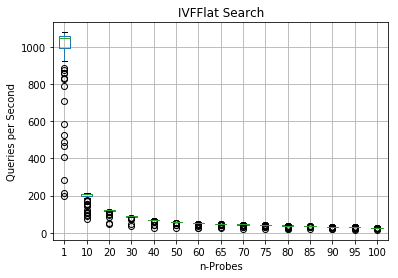

In [208]:
lser = {}
for i in range(len(n_list)):
    times = time_dict[n_list[i]]
    nacc = np.array(times)
    ser = pandas.Series(nacc)
    lser[n_list[i]] = ser

df = pandas.DataFrame(lser)                            
df.boxplot()
ax = plt.gca()
title = ax.set_title('IVFFlat Search')
ax.set_xlabel("n-Probes")
ax.set_ylabel("Queries per Second")

## Search Time for Number of Probes (LSH Index)

Text(0, 0.5, 'Queries per Second')

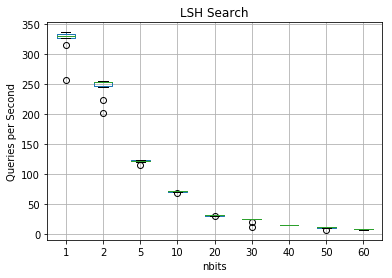

In [209]:
lser = {}
for i in range(len(nbit_list)):
    times = lsh_time_dict[nbit_list[i]]
    nacc = np.array(times)
    ser = pandas.Series(nacc)
    lser[nbit_list[i]] = ser

df = pandas.DataFrame(lser)                             
df.boxplot()
ax = plt.gca()
title = ax.set_title('LSH Search')
ax.set_xlabel("nbits")
ax.set_ylabel("Queries per Second")

## Check Recall (IVFFlat Index)

Recall = tp / (tp + fp)

In this case, recall is a better metric than accuracy because it does not include 
tn in the denominator. Also notice that recall and precision are always equal in this experiment because fp = fn.

Text(0, 0.5, 'Recall')

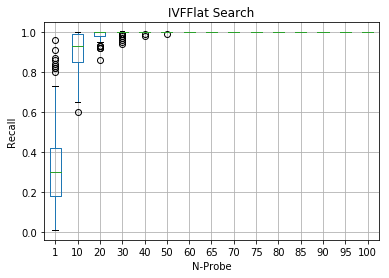

In [210]:
def recall(results):
    precision = (results['tp'])  / (results['tp'] +  results['fn'])
    return precision

def find_tf(approx, ground, db_size, k):
    tp = 0
    fp = 0
    fn = 0
    for i in range(len(ground)):
        if(approx[i] in ground):
            tp += 1
        else:
            fn += 1
            fp += 1   
    tn = db_size - k - fn
    result = {
        'tp':tp,
        'tn':tn,
        'fp':fp,
        'fn':fn
    }
    return result

rec_dict = {}                                          
for i in range(len(n_list)):
    recalls = []
    for j in range(len(gt)):
        approximation = nprobe_dict[n_list[i]]
        tf = find_tf(approximation[j], gt[j], nq, k)
        ca = recall(tf)
        recalls.append(ca)
    rec_dict[n_list[i]] = recalls  

lser = {}
for i in range(len(n_list)):
    recalls = rec_dict[n_list[i]]
    nacc = np.array(recalls)
    ser = pandas.Series(nacc)
    lser[n_list[i]] = ser

df = pandas.DataFrame(lser)                             # create pandas dataframe
df.boxplot()
ax = plt.gca()
title = ax.set_title('IVFFlat Search')
ax.set_xlabel("N-Probe")
ax.set_ylabel("Recall")

## Check Recall (LSH Index)

Text(0, 0.5, 'Recall')

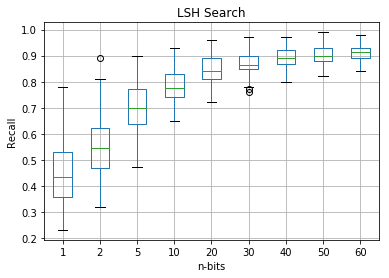

In [211]:
lsh_rec_dict = {}                                          
for i in range(len(nbit_list)):
    recalls = []
    for j in range(len(gt)):
        approximation = nbit_dict[nbit_list[i]]
        tf = find_tf(approximation[j], gt[j], nq, k)
        ca = recall(tf)
        recalls.append(ca)
    lsh_rec_dict[nbit_list[i]] = recalls  

lser = {}
for i in range(len(nbit_list)):
    recalls = lsh_rec_dict[nbit_list[i]]
    nacc = np.array(recalls)
    ser = pandas.Series(nacc)
    lser[nbit_list[i]] = ser

df = pandas.DataFrame(lser)                         
df.boxplot()
ax = plt.gca()
title = ax.set_title('LSH Search')
ax.set_xlabel("n-bits")
ax.set_ylabel("Recall")


## Compare IVFFLat and LSH Performance

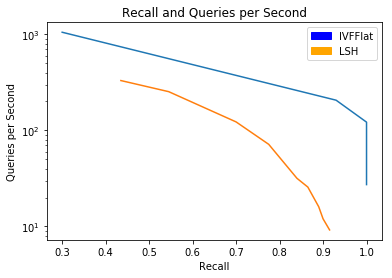

In [212]:
recalls = []
for i in range(len(n_list)):
    re = statistics.median(rec_dict[n_list[i]])
    recalls.append(re)

    
plt.plot(recalls, time_record)

lsh_recalls = []
for i in range(len(nbit_list)):
    re = statistics.median(lsh_rec_dict[nbit_list[i]])
    lsh_recalls.append(re)

IVFFlat_legend = mpatches.Patch(color='blue', label='IVFFlat')
LSH_legend = mpatches.Patch(color='orange', label='LSH')
plt.legend(handles=[IVFFlat_legend, LSH_legend])

plt.plot(lsh_recalls, lsh_time_record)
plt.title('Recall and Queries per Second')
plt.xlabel('Recall')
plt.ylabel('Queries per Second')
xmax = max(recalls)
ymax = max(time_record)
plt.yscale('log')
plt.show()